In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, \
    ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [57]:

class MyLogisticRegression:
    def __init__(self, learning_rate=0.001, epochs=1000, batch_size=32, reg_type=None, lambda_=0.01):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_type = reg_type 
        self.lambda_ = lambda_  
        self.weights = None
        self.bias = None
        self.test_acc = None

    def sigmoid(self, z):
        # Handling overflow in exp(-z)
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def hypothesis(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        base_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        if self.reg_type == 'l1': 
            reg_loss = self.lambda_ * np.sum(np.abs(self.weights))
        elif self.reg_type == 'l2': 
            reg_loss = (self.lambda_ / 2) * np.sum(self.weights ** 2)
        else:
            reg_loss = 0

        return base_loss + reg_loss

    def compute_accuracy(self, y_true, y_pred):
        predictions = (y_pred > 0.5).astype(int)
        return np.mean(predictions == y_true)

    def fit(self, X_train, y_train, X_val, y_val, patience=10):
        n_samples, n_features = X_train.shape
        self.weights = np.random.rand(n_features)
        self.bias = 0

        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        best_val_loss = np.inf
        patience_counter = 0

        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, n_samples, self.batch_size):
                end = min(start + self.batch_size, n_samples)
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                y_pred = self.hypothesis(X_batch)

                error = y_pred - y_batch
                gradient_weights = np.dot(X_batch.T, error) / self.batch_size
                gradient_bias = np.mean(error)

                if self.reg_type == 'l1':
                    gradient_weights += self.lambda_ * np.sign(self.weights) / self.batch_size
                elif self.reg_type == 'l2':
                    gradient_weights += self.lambda_ * self.weights / self.batch_size

                self.weights -= self.learning_rate * gradient_weights
                self.bias -= self.learning_rate * gradient_bias

            train_pred = self.hypothesis(X_train)
            val_pred = self.hypothesis(X_val)

            train_loss = self.compute_loss(y_train, train_pred)
            val_loss = self.compute_loss(y_val, val_pred)

            train_acc = self.compute_accuracy(y_train, train_pred)
            val_acc = self.compute_accuracy(y_val, val_pred)

            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)
            self.train_acc.append(train_acc)
            self.val_acc.append(val_acc)

            print(f"Epoch {epoch+1}/{self.epochs}")
            print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
                break
    
    def evaluate_test_accuracy(self, X_test, y_test):
        test_pred = self.hypothesis(X_test)
        self.test_acc = self.compute_accuracy(y_test, test_pred)
        print(f"Test Accuracy: {self.test_acc:.4f}")

    def evaluate_metrics(self, X_val, y_val):
        val_pred = self.hypothesis(X_val)
        val_pred_labels = (val_pred > 0.5).astype(int)
        
        cm = confusion_matrix(y_val, val_pred_labels)
        print("Confusion Matrix:\n", cm)

        precision = precision_score(y_val, val_pred_labels, zero_division=0)
        recall = recall_score(y_val, val_pred_labels)
        f1 = f1_score(y_val, val_pred_labels)
        roc_auc = roc_auc_score(y_val, val_pred_labels)
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC-AUC Score: {roc_auc:.4f}")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
    
    
    def plot_metrics(self):
        plt.figure(figsize=(12, 5))
    
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Over Epochs')
    
        plt.subplot(1, 2, 2)
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        if self.test_acc is not None:
            plt.axhline(y=self.test_acc, color='r', linestyle='--', label=f'Test Accuracy ({self.test_acc:.4f})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Over Epochs')
    
        plt.show()

In [58]:
data = pd.read_csv('Heart Disease.csv')
print(data.info())
print(data.isna().sum())
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

numerical_cols = ['age', 'cigsPerDay', 'BPMeds', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
categorical_cols = ['education', 'currentSmoker', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'male']

numerical_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

print(X.isna().sum())
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15 / (1 - 0.15),
                                                  random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  HeartDisease     4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB
None
male    

Epoch 1/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 19.2899, Training Accuracy: 0.1524
Validation Loss: 19.3661, Validation Accuracy: 0.1541
Epoch 5/1000
Training Loss: 3.5284, Training Accuracy: 0.7562
Validation Loss: 3.7432, Validation Accuracy: 0.7579
Epoch 6/1000
Training Loss: 3.6273, Training Accuracy: 0.7374
Validation Loss: 3.8427, Validation Accuracy: 0.7406
Epoch 7/1000
Training Loss: 3.6276, Training Accuracy: 0.7370
Validation Loss: 3.8412, Validation Accuracy: 0.7406
Epoch 8/1000
Training Loss: 3.6144, Training Accuracy: 0.7360
Validation Loss: 3.8268, Validation Accuracy: 0.7390
Epoch 9/1000
Training Loss: 3.6018, Training Accuracy: 0.7360
Validation

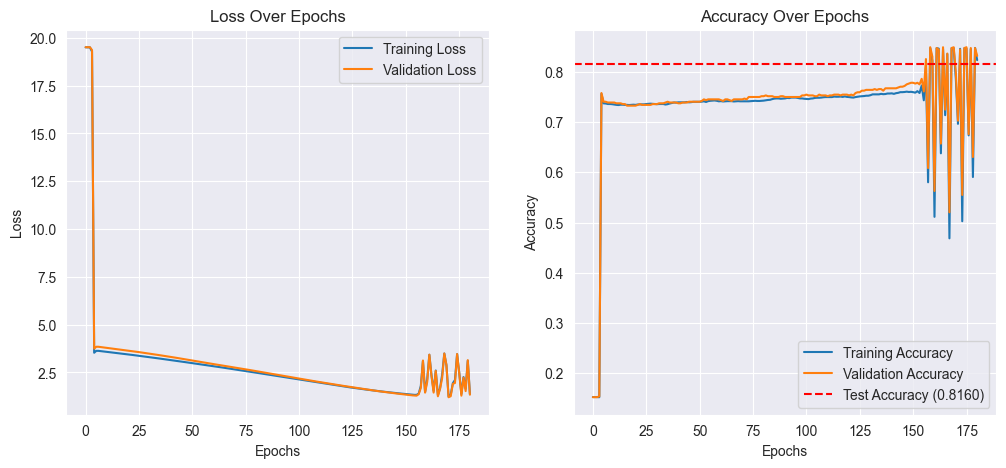

Test Accuracy: 0.8160


In [65]:
model = MyLogisticRegression(learning_rate=0.001, epochs=1000, batch_size=X_train.shape[0])

model.fit(X_train.values, y_train.values, X_val.values, y_val.values)
model.evaluate_test_accuracy(X_test.values, y_test.values)

model.plot_metrics()
print(f"Test Accuracy: {model.test_acc:.4f}")

Epoch 1/1000
Training Loss: 19.5862, Training Accuracy: 0.1527
Validation Loss: 19.5911, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 19.5803, Training Accuracy: 0.1527
Validation Loss: 19.5853, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 19.5777, Training Accuracy: 0.1527
Validation Loss: 19.5826, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 8.0487, Training Accuracy: 0.4076
Validation Loss: 7.8729, Validation Accuracy: 0.4308
Epoch 5/1000
Training Loss: 3.2756, Training Accuracy: 0.8277
Validation Loss: 3.2278, Validation Accuracy: 0.8333
Epoch 6/1000
Training Loss: 3.2737, Training Accuracy: 0.7953
Validation Loss: 3.2841, Validation Accuracy: 0.7987
Epoch 7/1000
Training Loss: 3.3857, Training Accuracy: 0.7593
Validation Loss: 3.4352, Validation Accuracy: 0.7673
Epoch 8/1000
Training Loss: 3.4375, Training Accuracy: 0.7502
Validation Loss: 3.4930, Validation Accuracy: 0.7516
Epoch 9/1000
Training Loss: 3.4344, Training Accuracy: 0.7492
Validation L

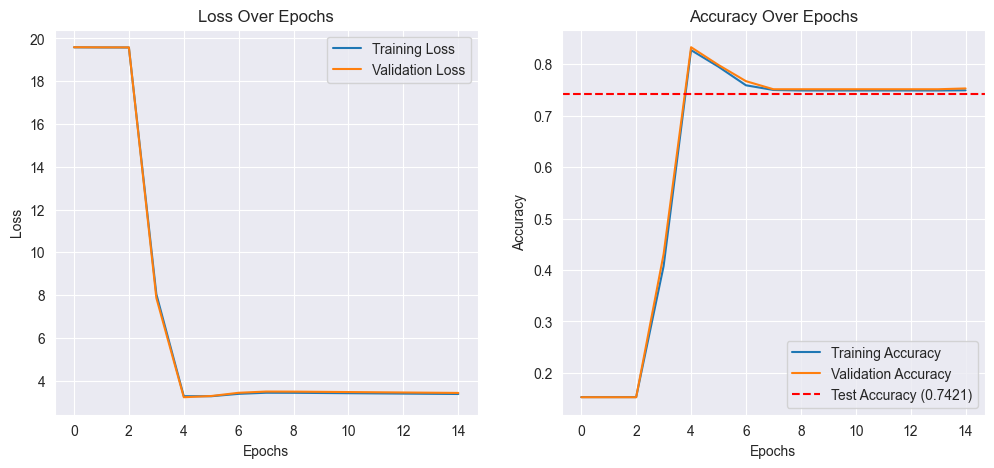

Test Accuracy: 0.7421


In [62]:
model = MyLogisticRegression(learning_rate=0.001, epochs=1000, reg_type="l1", batch_size=X_train.shape[0])
model.fit(X_train.values, y_train.values, X_val.values, y_val.values)

model.evaluate_test_accuracy(X_test.values, y_test.values)

model.plot_metrics()

print(f"Test Accuracy: {model.test_acc:.4f}")

Epoch 1/1000
Training Loss: 19.5420, Training Accuracy: 0.1527
Validation Loss: 19.5469, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 19.5396, Training Accuracy: 0.1527
Validation Loss: 19.5446, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 19.5379, Training Accuracy: 0.1527
Validation Loss: 19.5429, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 19.4965, Training Accuracy: 0.1524
Validation Loss: 19.4631, Validation Accuracy: 0.1541
Epoch 5/1000
Training Loss: 7.2649, Training Accuracy: 0.5236
Validation Loss: 7.4911, Validation Accuracy: 0.5142
Epoch 6/1000
Training Loss: 3.9270, Training Accuracy: 0.7519
Validation Loss: 4.1233, Validation Accuracy: 0.7453
Epoch 7/1000
Training Loss: 4.0315, Training Accuracy: 0.7394
Validation Loss: 4.2509, Validation Accuracy: 0.7484
Epoch 8/1000
Training Loss: 4.0597, Training Accuracy: 0.7347
Validation Loss: 4.2805, Validation Accuracy: 0.7453
Epoch 9/1000
Training Loss: 4.0577, Training Accuracy: 0.7340
Validation

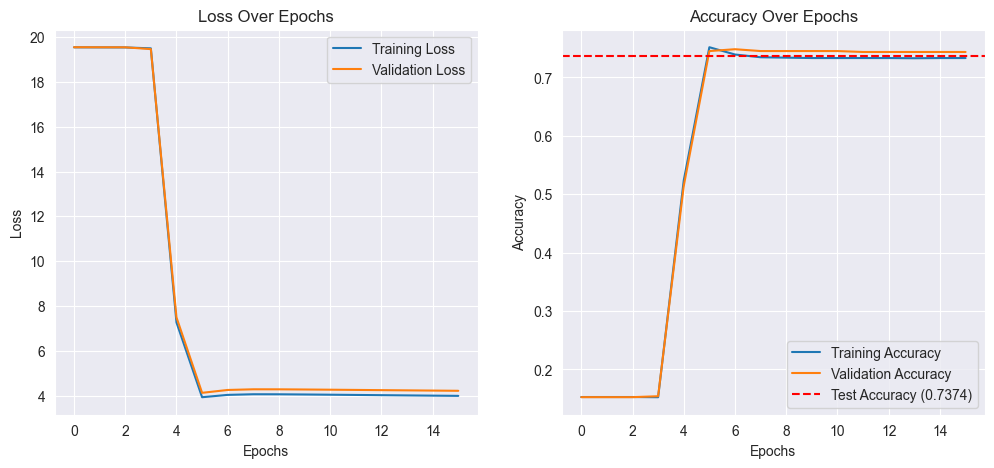

Test Accuracy: 0.7374


In [63]:
model = MyLogisticRegression(learning_rate=0.001, epochs=1000, reg_type="l2", batch_size=X_train.shape[0])
model.fit(X_train.values, y_train.values, X_val.values, y_val.values)

model.evaluate_test_accuracy(X_test.values, y_test.values)

model.plot_metrics()

print(f"Test Accuracy: {model.test_acc:.4f}")

# F: Model Performance Comparison: No Regularization, L1, and L2 with Early Stopping

## Effect of Early Stopping on Overfitting and Generalization

### 1. No Regularization 
- **Loss**: Both training and validation loss decrease steadily, but validation loss fluctuates towards the end, indicating overfitting.
- **Accuracy**: Training accuracy remains high, but validation accuracy diverges at later epochs. Early stopping helps control overfitting but performance suffers (Test Accuracy: **0.8160**).

### 2. L1 Regularization 
- **Loss**: Loss converges quickly and remains stable. Both training and validation loss are close, showing better generalization.
- **Accuracy**: Validation accuracy closely follows training accuracy with less fluctuation. Early stopping prevents overfitting (Test Accuracy: **0.7421**).

### 3. L2 Regularization 
- **Loss**: Similar to L1, the loss remains stable after initial convergence. Overfitting is minimal.
- **Accuracy**: Validation accuracy aligns with training accuracy, with early stopping ensuring a smoother fit (Test Accuracy: **0.7374**).

### Conclusion
- Early stopping helped removing overfitting, especially with L1 and L2 regularization.
- Regularization (L1, L2) enhances generalization compared to no regularization.
